In [195]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import matplotlib.pyplot as plt
import numpy as np
from typing import OrderedDict

**Defining class**

In [196]:

class VGG11_CIFR10(nn.Module):
  def __init__(self, num_channels = 3, num_classes = 10):
    super(VGG11_CIFR10, self).__init__();
    self.num_channels = num_channels;
    self.num_classes = num_classes;
    # Convolution and Pooling
    self.convolution_layers = nn.Sequential(OrderedDict([
                                                       ('conv1', nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, padding=1)),
                                                       ('relu1', nn.ReLU(inplace=True)),
                                                       ('Maxpool1', nn.MaxPool2d(kernel_size=2,stride=2)), # Reducing the resulting image to half

                                                       ('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)),
                                                       ('relu2', nn.ReLU(inplace=True)),
                                                       ('Maxpool2', nn.MaxPool2d(kernel_size=2,stride=2)), # Reducing the resulting image to half

                                                       ('conv3a', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)),
                                                       ('relu3a', nn.ReLU(inplace=True)),
                                                       ('conv3b', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)),
                                                       ('relu3b', nn.ReLU(inplace=True)),
                                                       ('Maxpool3', nn.MaxPool2d(kernel_size=2,stride=2)), # Reducing the resulting image to half

                                                       ('conv4a', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)),
                                                       ('relu4a', nn.ReLU(inplace=True)),
                                                       ('conv4b', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)),
                                                       ('relu4b', nn.ReLU(inplace=True)),
                                                       ('Maxpool4', nn.MaxPool2d(kernel_size=2,stride=2)), # Reducing the resulting image to half

                                                       ('conv5a', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)),
                                                       ('relu5a', nn.ReLU(inplace=True)),
                                                       ('conv5b', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)),
                                                       ('relu5b', nn.ReLU(inplace=True)),
                                                       # Here the dimension of the features will be 512 * 2 * 2
                                                       ('Maxpool5', nn.MaxPool2d(kernel_size=2,stride=2)), # Reducing the resulting image to half
                                                       # after Maxpool5 the dimension of the image becomes 512 * 1 * 1

                                ]))
    # Fully connected Layers
    self.fc = nn.Sequential(OrderedDict([
                                       ('fc1', nn.Linear(in_features=512*1*1, out_features=4096)),
                                       ('relu1', nn.ReLU(inplace=True)),
                                       ('Dropout1', nn.Dropout(0.5)),

                                       ('fc2', nn.Linear(in_features=4096, out_features=4096)),
                                       ('relu2', nn.ReLU(inplace=True)),
                                       ('Dropout2', nn.Dropout(0.5)),

                                       ('fc3', nn.Linear(in_features=4096, out_features=1000)),
                                       ('relu3', nn.ReLU(inplace=True)),
                                       ('Dropout3', nn.Dropout(0.5)),

                                       ('fc_out', nn.Linear(in_features=1000, out_features=10))
                                ]))


# forward Prop
  def forward(self, x):
    x = self.convolution_layers(x);
    # flatten the data
    x = torch.flatten(x, 1);
    # Pass thorugh Fully connected layers
    x = self.fc(x);
    return x

In [197]:
# Query for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

cuda
1
Tesla P100-PCIE-16GB


In [198]:
epochs = 30 # ideal = 59
batch_size = 128
learning_rate = 0.01
momentum = 0.9 # changed from 0.9 to 0.09
wt_decay = 0.0005

In [199]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize the input data to mean = 0.5 and SD = 0.5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [200]:
cnn_model = VGG11_CIFR10().to(device=device)

# Using Xavier initialization weights and Biases for convolutional layers
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.zero_()

cnn_model.apply(weights_init)  # Enable this to initialize the weights

# for param in cnn_model.parameters():
#   print("Total number of parameters : ",param.numel())
#   print("Type : ", type(param), "\tSize : ", param.size())

VGG11_CIFR10(
  (convolution_layers): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3a): ReLU(inplace=True)
    (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3b): ReLU(inplace=True)
    (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4a): ReLU(inplace=True)
    (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4b): ReLU(inplace=T

In [201]:
#  loss function
criterion = nn.CrossEntropyLoss()

# the optimizer
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=wt_decay, nesterov=True ) #  , weight_decay=wt_decay
                              # These parameters are taken from the section 3.1 of the paper https://arxiv.org/pdf/1409.1556.pdf on VGGNet

[Epoch : 1 , Average Training loss: 2.286349
[Epoch : 2 , Average Training loss: 1.847736
[Epoch : 3 , Average Training loss: 1.548796
[Epoch : 4 , Average Training loss: 1.243725
[Epoch : 5 , Average Training loss: 1.012984
[Epoch : 6 , Average Training loss: 0.847155
[Epoch : 7 , Average Training loss: 0.709574
[Epoch : 8 , Average Training loss: 0.597108
[Epoch : 9 , Average Training loss: 0.499356
[Epoch : 10 , Average Training loss: 0.411063
[Epoch : 11 , Average Training loss: 0.347478
[Epoch : 12 , Average Training loss: 0.278241
[Epoch : 13 , Average Training loss: 0.231870
[Epoch : 14 , Average Training loss: 0.192758
[Epoch : 15 , Average Training loss: 0.167511
[Epoch : 16 , Average Training loss: 0.134319
[Epoch : 17 , Average Training loss: 0.113491
[Epoch : 18 , Average Training loss: 0.100728
[Epoch : 19 , Average Training loss: 0.084251
[Epoch : 20 , Average Training loss: 0.078015
[Epoch : 21 , Average Training loss: 0.071956
[Epoch : 22 , Average Training loss: 0.0627

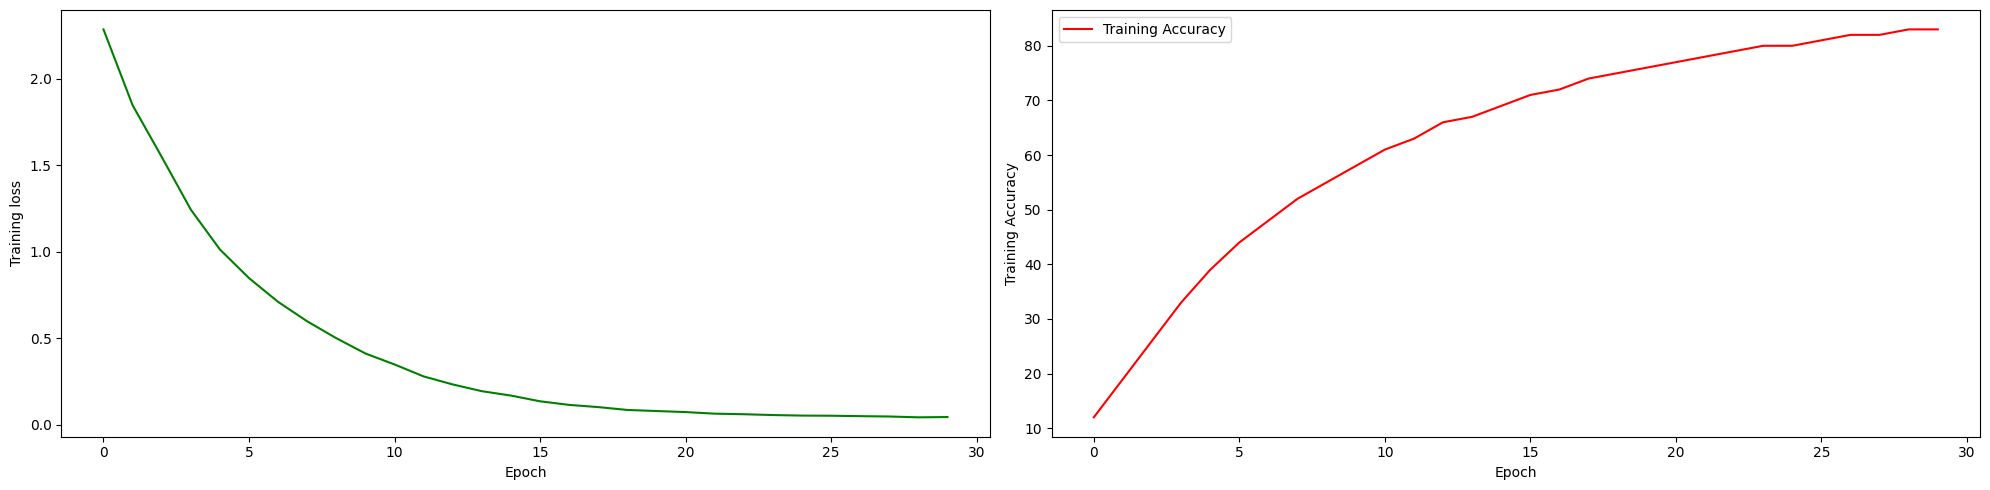


Training Finished with accuracy :  83


In [202]:
training_error = []   # To record Training error through the training process
interm_accuracy = []  # To record the intermediate accuracy values for plotting
count = 0
total = 0
correct = 0

for epoch in range(epochs):
  #set the model in training mode
  cnn_model.train()
  running_loss = 0.0
  interm_total = 0.0
  interm_correct = 0.0

  for i, data in enumerate(trainloader):
    count = count + 1
    inputs, labels = data
    inputs = inputs.to(device)  # To perform on the available GPU
    labels = labels.to(device)

    # reset the grads to Zero
    optimizer.zero_grad()

    # forward pass
    outputs = cnn_model(inputs)

    # calculate loss
    loss = criterion(outputs, labels)

    # Back prop
    loss.backward()

    # Gradient update
    optimizer.step()

    running_loss += loss.item()

    predicted_probability, predicted = torch.max(outputs.data, 1) # each input image will have 10 probablities for classification,
                                                                  # from that we need to pick the maximum probability class as our predicted class
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    interm_total += labels.size(0)
    interm_correct += (predicted == labels).sum().item()
    
  avg_training_loss = running_loss / len(trainloader);
  print(f'[Epoch : {epoch + 1} , Average Training loss: {avg_training_loss:.6f}') # running_loss / 2000:.3f
  training_error.append(avg_training_loss)
  interm_accuracy.append((100 * correct)//total)
  running_loss = 0.0

# Plot the computed stats
fig=plt.figure(figsize=(20, 5))

fig.add_subplot(1,2,1)
plt.plot(training_error, label='Training Loss', color='g')
plt.xlabel('Epoch')
plt.ylabel('Training loss')

fig.add_subplot(1,2,2)
plt.plot(interm_accuracy, label='Training Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nTraining Finished with accuracy : ", ((100 * correct)//total) )

[Step :    10] , Average Validation loss: 1.0009129822254181
[Step :    20] , Average Validation loss: 1.1771720051765442
[Step :    30] , Average Validation loss: 1.0538588166236877
[Step :    40] , Average Validation loss: 0.9300571560859681
[Step :    50] , Average Validation loss: 1.0200230598449707
[Step :    60] , Average Validation loss: 1.075658231973648
[Step :    70] , Average Validation loss: 1.0247437715530396


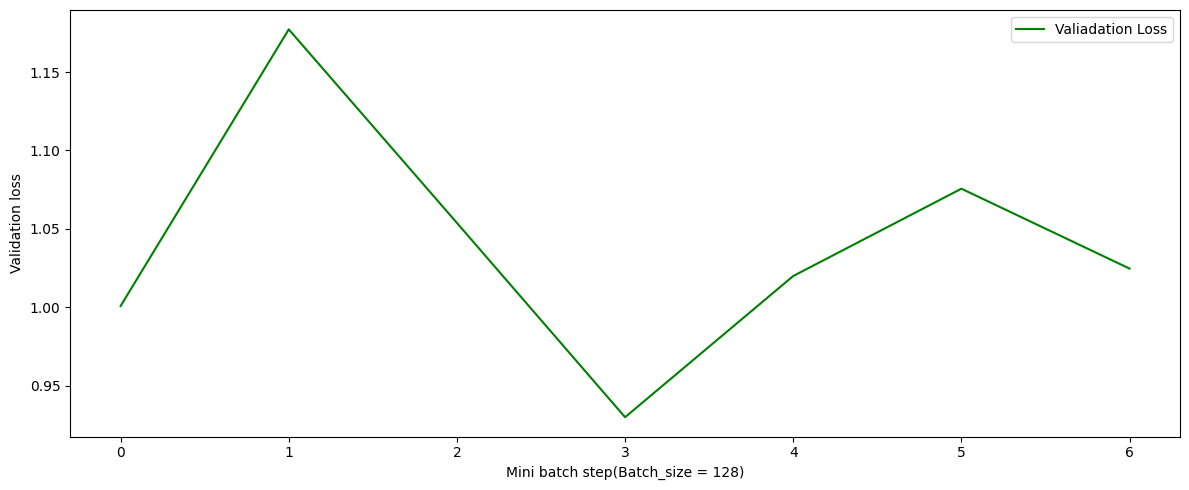


 Accuracy of the network on the 10000 test images: 79 %


In [203]:
correct = 0
total = 0
count = 0
validation_error = []
prediction_accuracy = []
validation_running_loss = 0.0
cnn_model.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader):
        count+=1
        images, labels = data
        
        images = images.to(device)  # To perform on the available GPU if present else on cpu
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = cnn_model(images) # forward pass

        loss = criterion(outputs, labels)
        validation_running_loss += loss.item()

        predicted_probability, predicted = torch.max(outputs.data, 1) # each input image will have 10 probablities for classification,
                                                                      # from that we need to pick the maximum probability class as our predicted class

        total += labels.size(0)
        # print((predicted == labels))
        correct += (predicted == labels).sum().item()
        # print(total , " , ",correct)
        if ((i+1) % 10) == 0:
          # print("inside loop")
          avg_validating_loss = validation_running_loss / 10;
          print(f'[Step : {i + 1:5d}] , Average Validation loss: {avg_validating_loss}') # running_loss / 2000:.3f
          validation_error.append(avg_validating_loss)
          validation_running_loss = 0.0

# Plot the stats recoreded in the above steps
plt.figure(figsize=(12, 5))
plt.plot(validation_error, label='Valiadation Loss', color = 'g')
plt.xlabel(f'Mini batch step(Batch_size = {batch_size})')
plt.ylabel('Validation loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f'\n Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [204]:
#save the model for inference
PATH = './cifar10_vgg_net.pth'
torch.save(cnn_model.state_dict(), PATH)

In [205]:
# Compare the results of the Ground Truth vs Prediction
saved_model =  VGG11_CIFR10().to(device)
# Load the CNN Model
saved_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

<class 'list'> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
<class 'torch.Tensor'> torch.Size([50, 10])


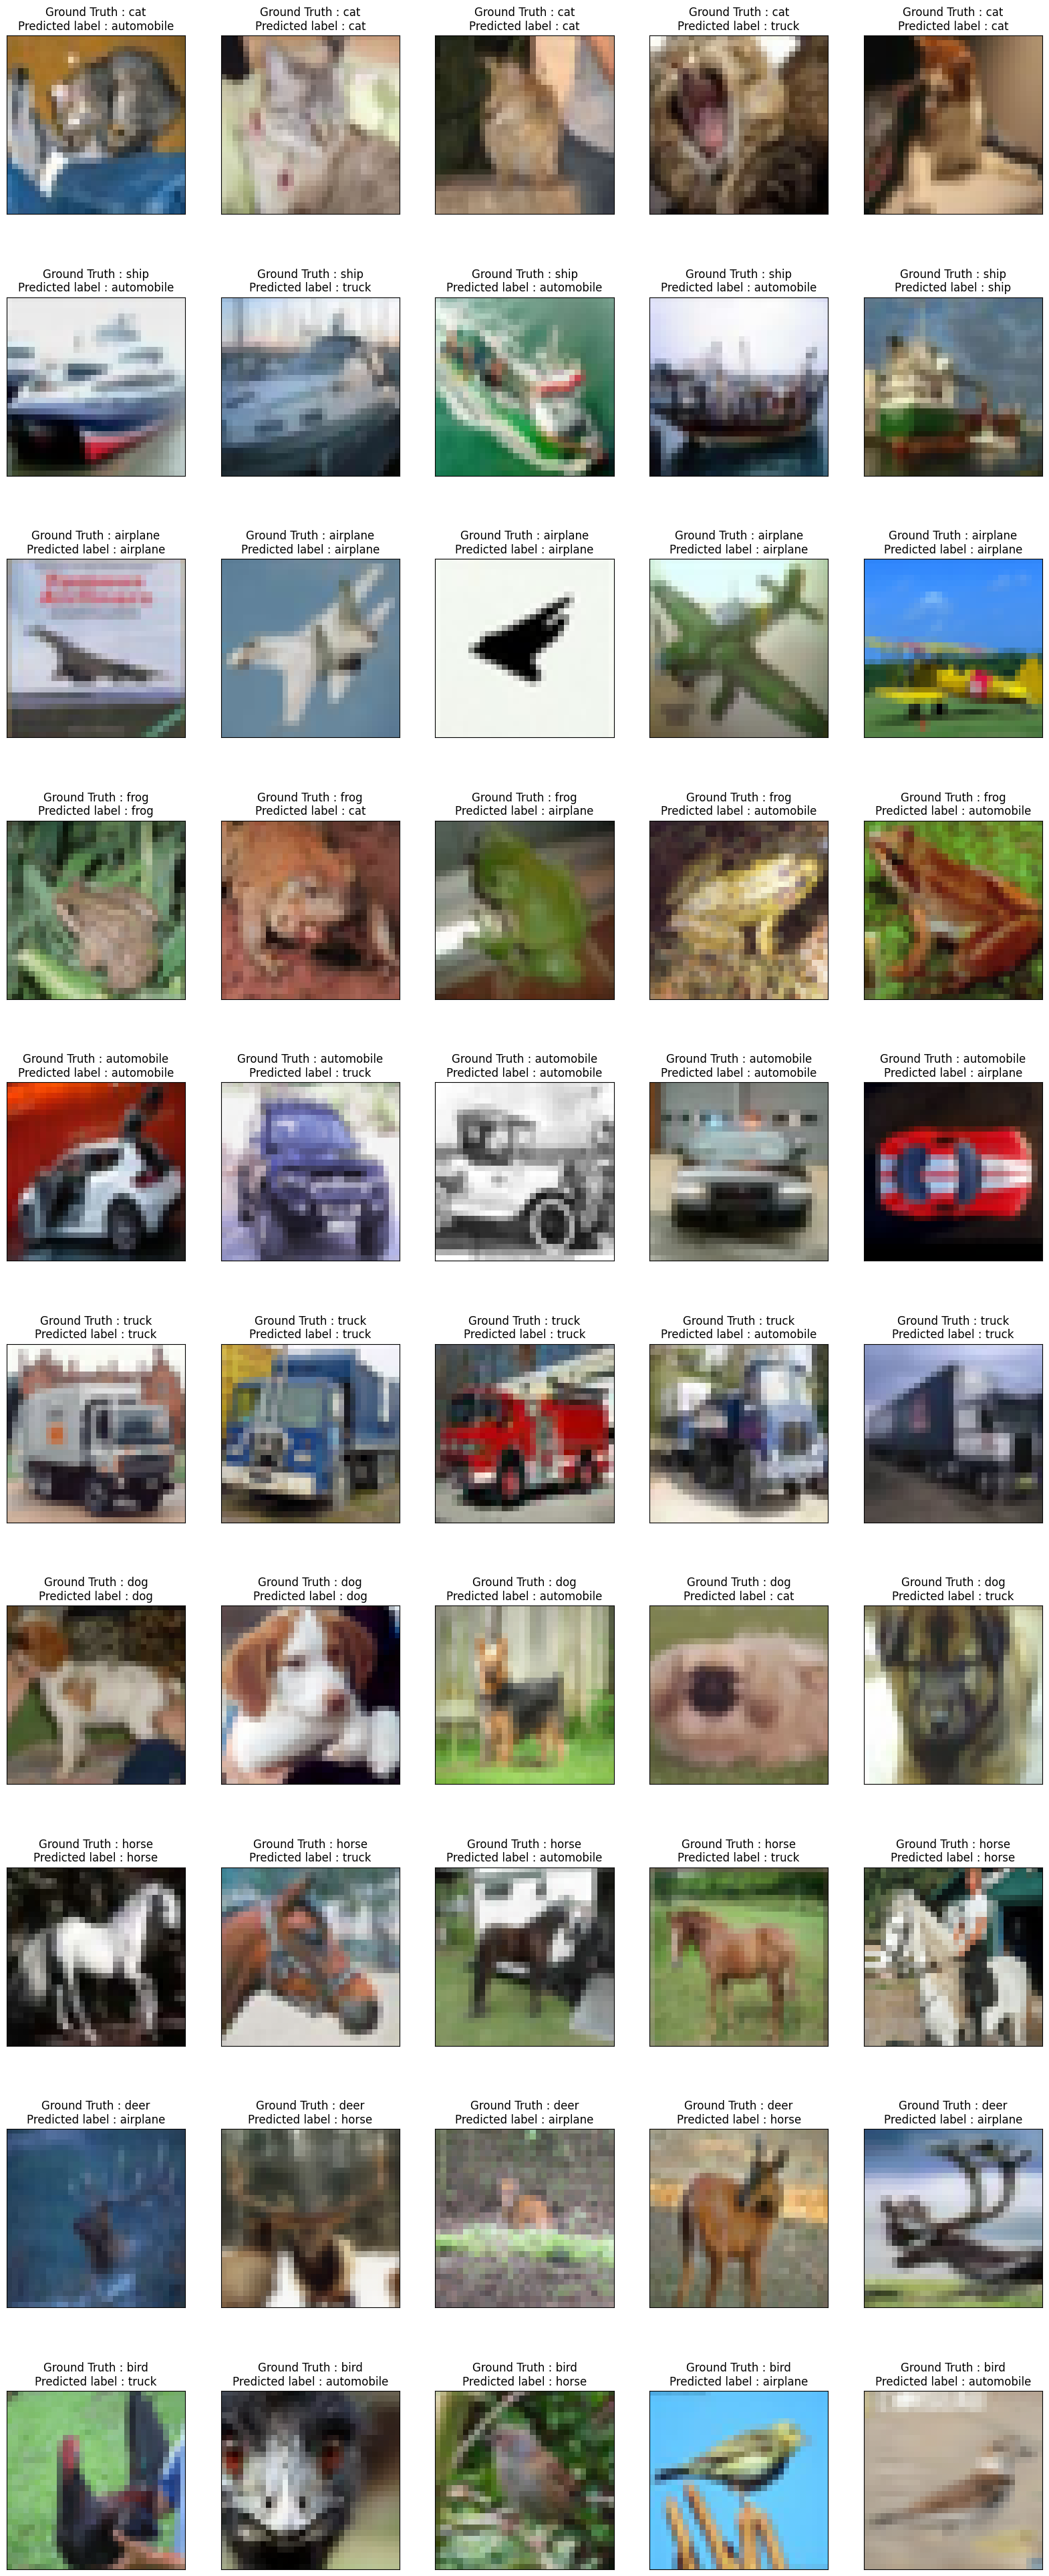

<Figure size 640x480 with 0 Axes>

In [206]:
from itertools import count
#since data shuffling has been turned on earlier, now we will load the data using pickle to verify the images class wise
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

file = r'./data/cifar-10-batches-py/test_batch'
meta_file = r'./data/cifar-10-batches-py/batches.meta'
meta_data = unpickle(meta_file)
ground_truth = unpickle(file)

# take the images data from batch data
images = ground_truth['data']
# reshape and transpose the images
# print("images type : ", type(images), "shape : ", images.shape)
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
# take labels of the images 
labels = ground_truth['labels']
# label names of the images
label_names = meta_data['label_names']

print(type(label_names),label_names)

rows, columns = 10, 5
# print(type(images), images.shape)
tmp_dict = dict()
# pick 5 images from each class from test_batch
for i, label in enumerate(labels):
    if len(tmp_dict.setdefault(label, [])) < 5:
        tmp_dict[label].append(i)

imageId =  np.array(list(tmp_dict.values())).flatten()

# print('Generated Image ID : ', imageId, '\nShape : ', imageId.shape)

# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

images_torch = torch.from_numpy(images.astype(np.float32)).to(device)
images_torch = images_torch.permute(0, 3, 1, 2)

# print("images: ", type(images_torch), " , ", images_torch.shape)
trained_outputs = saved_model(images_torch)
print(type(trained_outputs), trained_outputs.shape)
predicted_probability, predicted = torch.max(trained_outputs, 1)

# define figure
fig=plt.figure(figsize=(20, 50))
# visualize these random images
for i, pred_val in enumerate(predicted):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(f'Ground Truth : {label_names[labels[i]]}\nPredicted label : {label_names[pred_val.item()]}'))

plt.show()
plt.subplots_adjust(hspace=0.5)


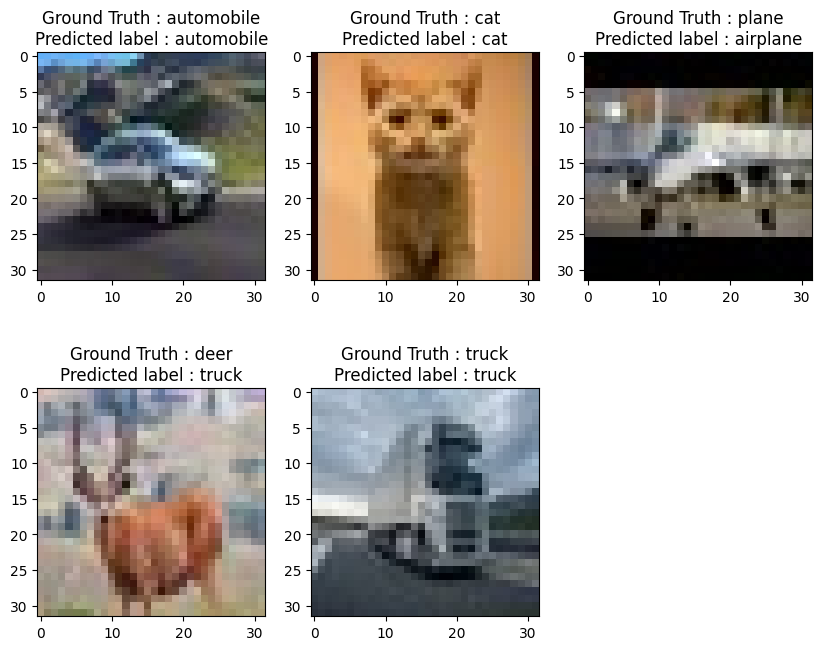

<Figure size 640x480 with 0 Axes>

In [207]:
random_img_path = '/kaggle/input/cnns-dataset/'
labels = ['automobile', 'cat', 'plane', 'deer', 'truck']
predicted_labels = []
images_list = os.listdir(random_img_path)
all_image_data = []

reloaded_model =  VGG11_CIFR10().to(device)
reloaded_model.load_state_dict(torch.load('./cifar10_vgg_net.pth'))
reloaded_model.eval() 

fig=plt.figure(figsize=(10, 8))

# add images to a np-array
for image in images_list:
    img = plt.imread(random_img_path+image)
    all_image_data.append(img)
    
concat_images = np.stack(all_image_data, axis = 0)
concat_images = concat_images.transpose(0, 3, 1,2)

images_torch = torch.from_numpy(concat_images.astype(np.float32)).to(device)
trained_outputs = saved_model(images_torch)
predicted_probability, predicted = torch.max(trained_outputs, 1)
# print(type(predicted),predicted.shape)


for i, image in enumerate(images_list):
#     print(image)
    fig.add_subplot(2,3,i+1)
    img = plt.imread(random_img_path+image)
    plt.imshow(img)
    
    #perform classification
    img_torch = torch.from_numpy(img.astype(np.float32)).to(device)
#     print(type(img_torch), img_torch.shape)
    img_torch = img_torch.permute(2,0,1)
#     print(type(img_torch), img_torch.shape)
    outs = reloaded_model(images_torch)
#     print(type(outs), outs.shape)
    new_predicted_probability, new_predicted = torch.max(outs, 1)
#     print(type(new_predicted), new_predicted.shape, new_predicted)
    plt.title("{}"
          .format(f'Ground Truth : {labels[i]}\nPredicted label : {label_names[predicted[i]]}'))
    
plt.show()
plt.subplots_adjust(hspace=0.5)